# SPC Data Analysis

---

[Alejandro Ciuba](https://alejandrociuba.github.io), alejandrociuba@pitt.edu

---

## Summary

This Jupyter Notebook explores the Semantic Pleonasm Corpus from [this paper](). The goals are:

1. General exploration of the corpus, including word counts, quantitative plots, etc.
2. Discovery of potential machine-learning features for semantic pleonasm detection.
---

## Setup

### Imports

In [89]:
from collections import defaultdict

from nltk import (
    word_tokenize,
    FreqDist,
    )

from nltk.corpus import stopwords
from pathlib import Path

import pandas as pd
import seaborn as sns
import string

### Globals

In [90]:
SPC = Path("./data/SPC-FOLD/")
data = SPC / "SPC.json"

In [91]:
stop_tokens = set(word_tokenize(' '.join(stopwords.words(fileids='english'))))

### Functions

In [92]:
def tokenize(sentence: str) -> list[str]:
    return word_tokenize(sentence.strip().lower())

In [93]:
def strip_punct(sentence: str) -> str:
    return ''.join(filter(lambda x: x not in string.punctuation, sentence)) # Gotten from GeeksForGeeks
    

In [94]:
def preprocess(string: str) -> str:
    return strip_punct(string.strip().lower())

In [95]:
def full_sentence_tokenize(row: pd.Series) -> list[str]:
    before, after, first, second = row.before, row.after, row['first'], row.second
    return before + [first, second] + after

In [96]:
# Remove stop words to compare non-pleonasm content words and pleonasm content words
def remove_stopwords(tokens: list[str]) -> list[str]:
    return list(filter(lambda x: x not in stop_tokens and x not in ["``", "..."] and x not in string.punctuation, tokens))

In [97]:
def both_pleonasms(x: pd.Series) -> list[str]:
    return [x['first'], x.second] if x.consensus is not pd.NA else pd.NA

### Prolog Code

In [98]:
%pprint  # Disable pretty printing

Pretty printing has been turned OFF


In [99]:
df = pd.read_json(data, lines=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   after        3019 non-null   object
 1   consensus    3019 non-null   object
 2   second       3019 non-null   object
 3   before       3019 non-null   object
 4   annotations  3019 non-null   object
 5   first        3019 non-null   object
 6   fold         3019 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 165.2+ KB


In [100]:
### Preprocessing
df.after = df.after.map(preprocess)
df.before = df.before.map(preprocess)

df['first'] = df['first'].map(preprocess)
df.second = df.second.map(preprocess)

df.after = df.after.map(tokenize)
df.before = df.before.map(tokenize)

# Getting full sentences now guarantees consistency
df['full_sent'] = df.apply(full_sentence_tokenize, axis=1)

df["before_count"] = df.before.map(len)
df["after_count"] = df.after.map(len)

df["consensus"] = df.consensus.map(str.lower)
df["consensus"] = df.consensus.replace(to_replace="neither", value=pd.NA)

# Since we need the original first and second rows to construct the sentences
# We create new columns which only contain data for positive pleonasm instances
df["pleonasms"] = df.apply(both_pleonasms, axis=1)
df["first_p"] = df.pleonasms.map(lambda x: x[0] if x is not pd.NA else pd.NA)
df["second_p"] = df.pleonasms.map(lambda x: x[1] if x is not pd.NA else pd.NA)

df.head(10)

,after,consensus,second,before,annotations,first,fold,full_sent,before_count,after_count,pleonasms,first_p,second_p
0,"[can, of, flat, black, krylon]",stinking,stinking,"[i, walk, into, lowes, knowing, exactly, what,...",{'A3J2UG22S8BIW4': {'certainty': 'Somewhat cer...,lousy,3,"[i, walk, into, lowes, knowing, exactly, what,...",10,5,"[lousy, stinking]",lousy,stinking
1,[treat],delectable,delectable,"[support, your, local, business, and, be, rewa...","{'A2ESBX4C2Q6TQY': {'certainty': 'Certain', 'e...",yummy,1,"[support, your, local, business, and, be, rewa...",9,1,"[yummy, delectable]",yummy,delectable
2,"[thing, i, reflect, upon, the, lack, of, high,...",small,small,"[once, i, have, no, more, room, to, taste, eve...","{'A3B7TNVOISSZ2O': {'certainty': 'Certain', 'e...",slightest,2,"[once, i, have, no, more, room, to, taste, eve...",10,12,"[slightest, small]",slightest,small
3,[process],check,verification,"[they, ve, followed, suit, with, chase, and, n...","{'A2Z750U1HCWVEE': {'certainty': 'Certain', 'e...",check,1,"[they, ve, followed, suit, with, chase, and, n...",14,1,"[check, verification]",check,verification
4,"[gelatinous, purees, that, were, finessed, fla...",sick,green,"[also, i, thought, some, of, the, plating, had...",{'A2A1FS0KVLJ9ZT': {'certainty': 'Somewhat cer...,sick,0,"[also, i, thought, some, of, the, plating, had...",23,13,"[sick, green]",sick,green
5,"[and, happy, to, do, her, job]",cheerful,cheerful,[always],"{'AEWPAZBYA7XE': {'certainty': 'Certain', 'exp...",smiling,1,"[always, smiling, cheerful, and, happy, to, do...",1,6,"[smiling, cheerful]",smiling,cheerful
6,"[fruit, pulp]",plain,pure,"[freshly, squeezed, and, no, additives, just]",{'A1KAGE2AVL6ZGO': {'certainty': 'Somewhat cer...,plain,4,"[freshly, squeezed, and, no, additives, just, ...",6,2,"[plain, pure]",plain,pure
7,"[by, there, is, a, movie, theater, which, is, ...",next,close,"[fry, s, is]","{'A2OVMADBMBNWFK': {'certainty': 'Certain', 'e...",next,0,"[fry, s, is, next, close, by, there, is, a, mo...",3,11,"[next, close]",next,close
8,[],<NA>,thinking,"[restaurants, on, a, saturday, afternoon, and,...","{'A3J2UG22S8BIW4': {'certainty': 'Certain', 'e...",rational,2,"[restaurants, on, a, saturday, afternoon, and,...",18,0,<NA>,<NA>,<NA>
9,"[top, shelf]",top,top,"[the, beers, here, are, way]",{'A1GYO6CJMVA9ZA': {'certainty': 'Somewhat cer...,upper,1,"[the, beers, here, are, way, upper, top, top, ...",5,2,"[upper, top]",upper,top


In [101]:
# Focus on the important data
df = df.drop(labels=["annotations", "first", "second", "pleonasms"], axis=1)
df.head(10)

,after,consensus,before,fold,full_sent,before_count,after_count,first_p,second_p
0,"[can, of, flat, black, krylon]",stinking,"[i, walk, into, lowes, knowing, exactly, what,...",3,"[i, walk, into, lowes, knowing, exactly, what,...",10,5,lousy,stinking
1,[treat],delectable,"[support, your, local, business, and, be, rewa...",1,"[support, your, local, business, and, be, rewa...",9,1,yummy,delectable
2,"[thing, i, reflect, upon, the, lack, of, high,...",small,"[once, i, have, no, more, room, to, taste, eve...",2,"[once, i, have, no, more, room, to, taste, eve...",10,12,slightest,small
3,[process],check,"[they, ve, followed, suit, with, chase, and, n...",1,"[they, ve, followed, suit, with, chase, and, n...",14,1,check,verification
4,"[gelatinous, purees, that, were, finessed, fla...",sick,"[also, i, thought, some, of, the, plating, had...",0,"[also, i, thought, some, of, the, plating, had...",23,13,sick,green
5,"[and, happy, to, do, her, job]",cheerful,[always],1,"[always, smiling, cheerful, and, happy, to, do...",1,6,smiling,cheerful
6,"[fruit, pulp]",plain,"[freshly, squeezed, and, no, additives, just]",4,"[freshly, squeezed, and, no, additives, just, ...",6,2,plain,pure
7,"[by, there, is, a, movie, theater, which, is, ...",next,"[fry, s, is]",0,"[fry, s, is, next, close, by, there, is, a, mo...",3,11,next,close
8,[],<NA>,"[restaurants, on, a, saturday, afternoon, and,...",2,"[restaurants, on, a, saturday, afternoon, and,...",18,0,<NA>,<NA>
9,"[top, shelf]",top,"[the, beers, here, are, way]",1,"[the, beers, here, are, way, upper, top, top, ...",5,2,upper,top


In [102]:
pleonasms = FreqDist(df.first_p.to_list() + df.second_p.to_list())
content_words = FreqDist([tok for toks in df.full_sent.to_list() for tok in remove_stopwords(toks)])
all_words = FreqDist([tok for toks in df.full_sent.to_list() for tok in toks])  # Includes stop words as they can be pleonasms

---

## 1. General Exploration

### Descriptive Statistics

In [103]:
df.head(10)

,after,consensus,before,fold,full_sent,before_count,after_count,first_p,second_p
0,"[can, of, flat, black, krylon]",stinking,"[i, walk, into, lowes, knowing, exactly, what,...",3,"[i, walk, into, lowes, knowing, exactly, what,...",10,5,lousy,stinking
1,[treat],delectable,"[support, your, local, business, and, be, rewa...",1,"[support, your, local, business, and, be, rewa...",9,1,yummy,delectable
2,"[thing, i, reflect, upon, the, lack, of, high,...",small,"[once, i, have, no, more, room, to, taste, eve...",2,"[once, i, have, no, more, room, to, taste, eve...",10,12,slightest,small
3,[process],check,"[they, ve, followed, suit, with, chase, and, n...",1,"[they, ve, followed, suit, with, chase, and, n...",14,1,check,verification
4,"[gelatinous, purees, that, were, finessed, fla...",sick,"[also, i, thought, some, of, the, plating, had...",0,"[also, i, thought, some, of, the, plating, had...",23,13,sick,green
5,"[and, happy, to, do, her, job]",cheerful,[always],1,"[always, smiling, cheerful, and, happy, to, do...",1,6,smiling,cheerful
6,"[fruit, pulp]",plain,"[freshly, squeezed, and, no, additives, just]",4,"[freshly, squeezed, and, no, additives, just, ...",6,2,plain,pure
7,"[by, there, is, a, movie, theater, which, is, ...",next,"[fry, s, is]",0,"[fry, s, is, next, close, by, there, is, a, mo...",3,11,next,close
8,[],<NA>,"[restaurants, on, a, saturday, afternoon, and,...",2,"[restaurants, on, a, saturday, afternoon, and,...",18,0,<NA>,<NA>
9,"[top, shelf]",top,"[the, beers, here, are, way]",1,"[the, beers, here, are, way, upper, top, top, ...",5,2,upper,top


In [104]:
df[["before_count", "after_count"]].describe().T

,count,mean,std,min,25%,50%,75%,max
before_count,3019.0,11.366678,8.785853,0.0,5.0,9.0,16.0,77.0
after_count,3019.0,8.776747,8.441659,0.0,2.0,7.0,12.0,67.0


<Axes: xlabel='before_count', ylabel='Count'>

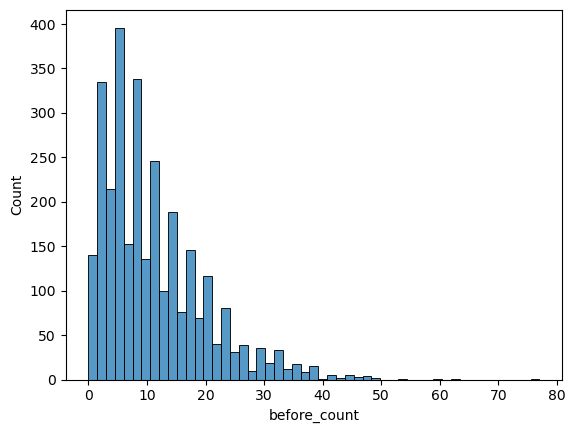

In [105]:
sns.histplot(df, x='before_count')

<Axes: xlabel='after_count', ylabel='Count'>

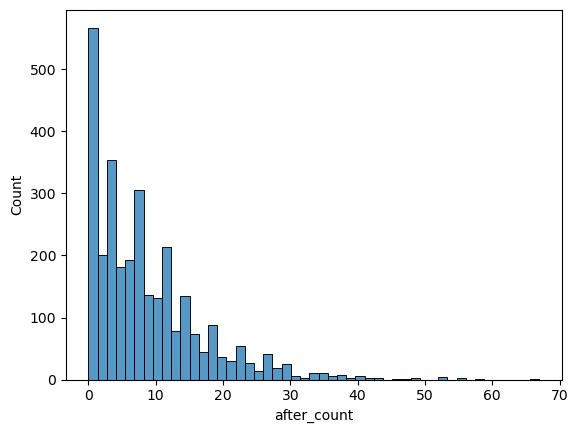

In [106]:
sns.histplot(df, x='after_count')

### Most Common Pleonasms

In [107]:
len(pleonasms.keys()) # Number of unique pleonasms

1747

In [108]:
pleonasms.most_common(11)  # No pleonasm is pd.NA

[(<NA>, 2566), ('little', 28), ('small', 27), ('large', 26), ('good', 19), ('big', 19), ('dirty', 18), ('soft', 15), ('bad', 13), ('complete', 13), ('regular', 13)]

In [109]:
len(pleonasms.hapaxes())

1044

#### Pleonasms Vs. General Content Words

In [110]:
content_words.most_common(10)

[('nt', 311), ('like', 275), ('place', 229), ('one', 185), ('get', 176), ('food', 169), ('good', 165), ('time', 134), ('great', 121), ('even', 118)]

In [111]:
len(content_words.hapaxes())

4610

Ratio between pleonasm vs. non-pleonasm instances of all words and pleonasm words

In [112]:
percentages = sorted(list(map(lambda x: pleonasms[x] / all_words[x] if x is not pd.NA else 0, all_words)))

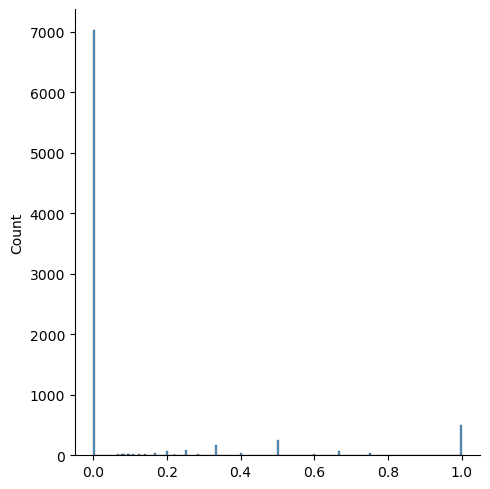

In [113]:
sns.displot(data=percentages)  # Plot the percentages as a distribution

In [114]:
percentages = sorted(list(map(lambda x: pleonasms[x] / all_words[x] if x is not pd.NA else 0, pleonasms)))

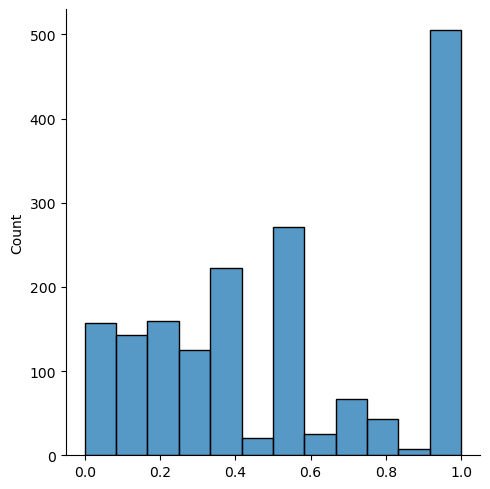

In [115]:
sns.displot(data=percentages)  # Plot the percentages as a distribution

Most pleonasms are frequently pleonasms while most non-pleonasms are never pleonasms.

---

## 2. SpaCy Exploration

What are the most common parts-of-speech for pleonasms?

In [116]:
import spacy

In [117]:
nlp = spacy.load('en_core_web_sm')

In [118]:
def get_nlp(x: str) -> spacy.tokens.Doc:
    return nlp(' '.join(x))

df['spacy'] = df.full_sent.map(get_nlp)

In [119]:
for row in df.sample(5, random_state=42).to_dict(orient='records'):
    print(' '.join(f"{word}({tok.pos_})" for word, tok in zip(row['full_sent'], row['spacy'])))
    print(row['first_p'], row['second_p'])

it(PRON) s(VERB) crack(NOUN) in(ADP) a(DET) giant(ADJ) large(ADJ) bowl(NOUN) filled(VERB) with(ADP) all(DET) the(DET) goodies(NOUN) that(PRON) you(PRON) pick(VERB) yourself(PRON) and(CCONJ) oozing(VERB) with(ADP) spicy(NOUN) goodness(NOUN)
giant large
chocolatte(PROPN) absolutely(ADV) deserves(VERB) merit(NOUN) as(ADP) a(DET) friendly(ADJ) quirky(ADJ) adorable(ADJ) little(ADJ) shop(NOUN) crammed(VERB) full(ADJ) of(ADP) treats(NOUN) of(ADP) all(DET) kind(NOUN)
None None
the(DET) music(NOUN) was(AUX) good(ADJ) but(CCONJ) a(DET) lot(NOUN) of(ADP) moments(NOUN) in(ADP) between(ADP) just(ADV) filled(VERB) with(ADP) silly(ADJ) goofy(NOUN) stuff(NOUN) that(PRON) anyone(PRON) painted(VERB) blue(ADJ) could(AUX) do(VERB)
silly goofy
leave(VERB) it(PRON) to(ADP) me(PRON) to(PART) get(VERB) all(DET) mushy(ADJ) sentimental(ADJ) in(ADP) a(DET) hallmark(NOUN) store(NOUN)
mushy sentimental
and(CCONJ) the(DET) toppings(NOUN) assortment(NOUN) is(AUX) heavenly(ADV) fresh(ADJ) strawberries(NOUN) blueberri

In [120]:
def get_pleonasm_pos(x: pd.Series, pos: int) -> str:
    if x[pos] is pd.NA:
        return pd.NA
    for tok in x['spacy']:
        if tok.text == x[pos]:
            return tok.pos_
    return pd.NA

In [125]:
df['first_p_pos'] = df.apply(get_pleonasm_pos, pos='first_p', axis=1)
df['second_p_pos'] = df.apply(get_pleonasm_pos, pos='second_p', axis=1)

In [126]:
df.first_p_pos.sample(2)

687     ADV
2796    ADJ
Name: first_p_pos, dtype: object

In [129]:
pos = FreqDist(df.first_p_pos.to_list() + df.second_p_pos.to_list())
pos.pop(pd.NA)
pos

FreqDist({'ADJ': 1823, 'NOUN': 987, 'VERB': 351, 'ADV': 225, 'PROPN': 41, 'ADP': 24, 'AUX': 6, 'NUM': 5, 'PRON': 4, 'DET': 3, ...})

<Axes: xlabel='Samples', ylabel='Percents'>

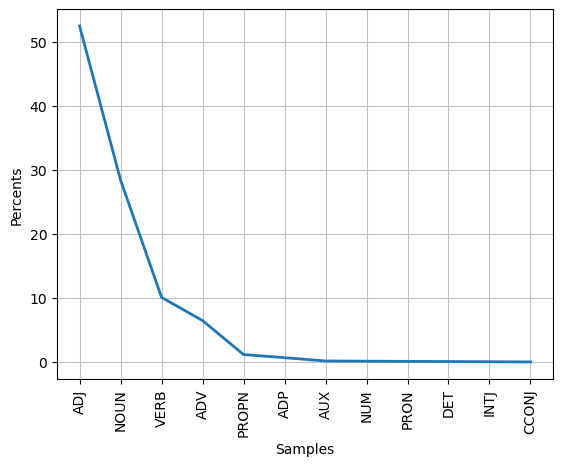

In [133]:
pos.plot(percents=True)

In [134]:
print(pos.freq("ADJ"))
print(pos.freq("NOUN"))

0.5250576036866359
0.2842741935483871


Let's do this per fold

0.5369822485207101
0.53125
0.5251479289940828
0.53601108033241


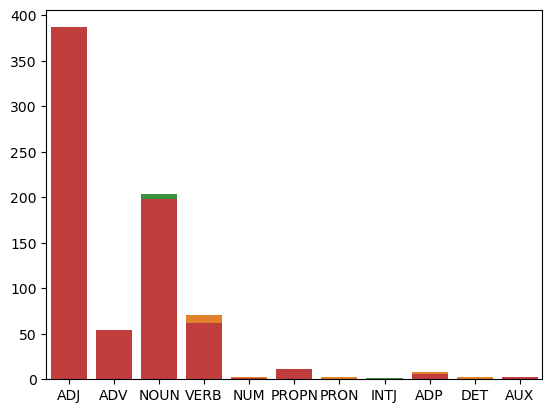

In [140]:
for i in range(4):

    fold_df = df[df.fold == i]

    pos = FreqDist(fold_df.first_p_pos.to_list() + fold_df.second_p_pos.to_list())
    pos.pop(pd.NA)

    sns.barplot(pos)
    print(pos.freq("ADJ"))

What is the POS distribution over all sentences and sentences containing pleonasms?

<Axes: >

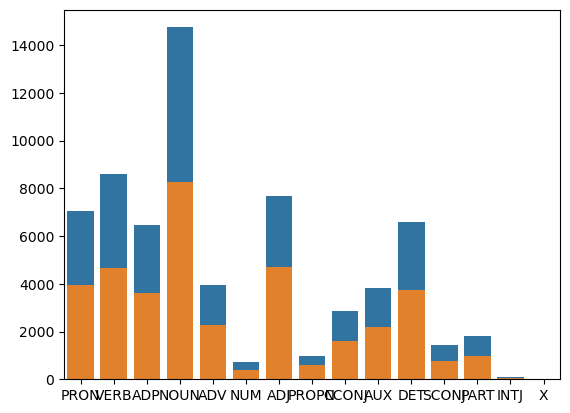

In [148]:
pos_all = FreqDist([tok.pos_ for doc in df.spacy for tok in doc])
sns.barplot(pos_all)

pos_all = FreqDist([tok.pos_ for doc in df[df['consensus'].isna() == False].spacy for tok in doc])
sns.barplot(pos_all)

## Pleonasm POS pairs

<Axes: xlabel='Samples', ylabel='Percents'>

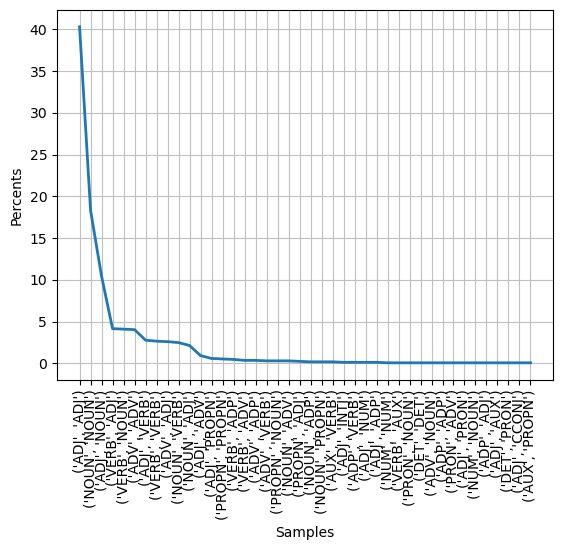

In [152]:
pos = FreqDist(zip(df.first_p_pos.to_list(), df.second_p_pos.to_list()))
pos.pop((pd.NA, pd.NA))
pos.plot(percents=True)

Let's see how common `<ADJ> <ADJ>` is in all sentences.

In [160]:
pairs = ("ADJ", "ADJ")
def get_pairs_count(x: spacy.Language) -> int:
    count = 0
    pos = [tok.pos_ for tok in x]
    for ind in range(len(pos)):
        if ind == len(x) - 1:
            return count
        if pos[ind] == pairs[0] and pos[ind + 1] == pairs[1]:
            count += 1

In [163]:
df['adj_count'] = df.spacy.map(get_pairs_count)
df['adj_count'].sample(10)

367     1
1581    0
1037    1
2879    2
2582    0
2634    0
2784    0
757     0
1655    0
2054    0
Name: adj_count, dtype: int64

<Axes: xlabel='adj_count', ylabel='count'>

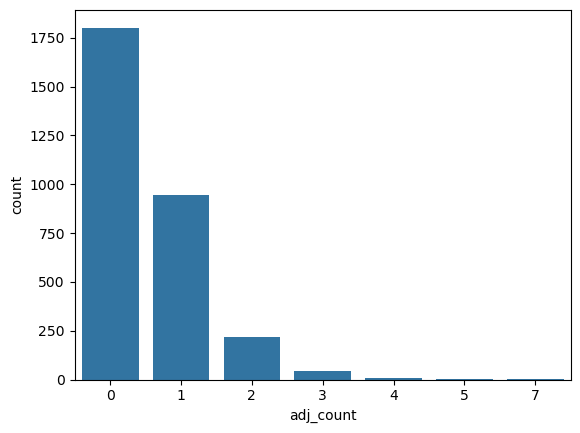

In [164]:
sns.countplot(df, x='adj_count')

/tmp/ipykernel_6206/1500241342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subdf['adj_count'] = subdf.spacy.map(get_pairs_count)


<Axes: xlabel='adj_count', ylabel='count'>

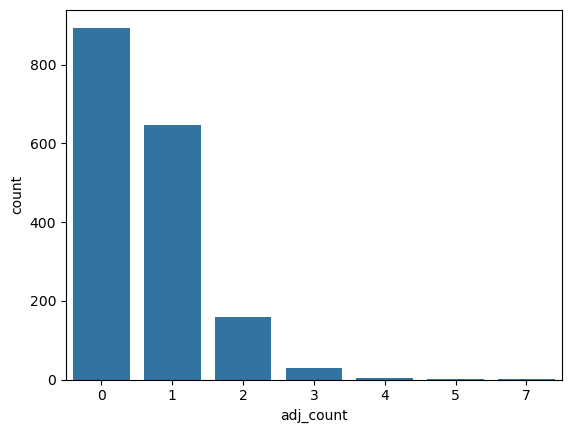

In [166]:
subdf = df[df['consensus'].isna() == False]
subdf['adj_count'] = subdf.spacy.map(get_pairs_count)
sns.countplot(subdf, x='adj_count')